# Data Generation and Analysis workshop
## Thursday Oct 10, 2024: Towards a Global Fit - part 2/2

We will move towards fitting an ensemble of Galactic binaries. We will first start with a single signal in a narrow frequency band, with known noise; and then introduce reversible jump MCMC to also estimate the number of sources.


This tutorial is adapted from this [LATW tutorial](https://github.com/mikekatz04/LATW/blob/main/tutorials/Tutorial6.ipynb).

# Requirements

Install and import the required packages

In [ ]:
!pip install eryn lisaanalysistools lisaconstants lisaorbits chainconsumer
!pip install git+https://gitlab.in2p3.fr/LISA/fastgb.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for lisaanalysistools: filename=lisaanalysistools-1.0.10-cp310-cp310-linux_x86_64.whl size=640980 sha256=f3651b00b49dc92d06d9f2d4e9baa0487befab87c355c953834fdba9dfd8408b
  Stored in directory: /root/.cache/pip/wheels/16/92/4b/858f634c076ca2a16cfde3fad26f162b20623e395851a3b37b
  Created wheel for oem: filename=oem-0.4.2-py3-none-any.whl size=24762 sha256=6f6087d2d2babb5e2fdbefa230cdfad12b9975125c1061ce9d0906651e4df26d
  Stored in directory: /root/.cache/pip/wheels/5b/6c/

In [ ]:
from typing import NamedTuple, Any

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let us define some helper functions.

In [ ]:
def computeAET(X, Y, Z):
    A = (Z - X)/np.sqrt(2)
    E = (X - 2*Y + Z)/np.sqrt(6)
    T = (X + Y + Z)*float(1./np.sqrt(3))
    return A, E, T

# GB waveform

We will use [fastgb](https://gitlab.in2p3.fr/LISA/fastgb) to generate Galactic Binary waveforms.



## Encapsulation

A GB source is described by 8 parameters. We can use a [`NamedTuple`](https://docs.python.org/3/library/typing.html#typing.NamedTuple) to encapsulate them. Similarly we can encapsulate the result waveforms. You can also use a dictionary to achieve it.



In [ ]:
class GBSource(NamedTuple):
  """Encapsulator for GB source parameters."""

  amp: Any
  """Amplitude"""

  f0: Any
  """Frequency"""

  fdot: Any
  """Frequency derivative"""

  phi0: Any
  """Initial phase"""

  inc: Any
  """Inclination angle"""

  psi: Any
  """Polarisation angle"""

  lam: Any
  """Ecliptic longitude"""

  beta: Any
  """Ecliptic latitude"""

  def asdict(self):
    """Convert to dictionary."""
    return self._asdict()

  @classmethod
  def keys(cls):
    """Return the keys."""
    return cls._fields


class GBWaveform(NamedTuple):
  """Encapsulator for GB waveform."""

  A: Any
  """A channel"""

  E: Any
  """E channel"""

  T: Any
  """T channel"""

  frequencies: Any
  """Frequencies"""

## Waveform generation

- Documentation of FastGB: https://lisa.pages.in2p3.fr/fastgb/

In [ ]:
from fastgb import fastgb


class GBGen:
  """Class to generate GB waveforms."""

  def __init__(self, fastgb_gen: fastgb.FastGB):
    self.fastgb_gen = fastgb_gen

  def __call__(self, params: GBSource, squeeze=False):
    """Generate a GB waveform."""
    params_dict = params.asdict()
    # FastGB accepts the parameters in a fixed order
    fastgb_param_order = ["f0", "fdot", "amp", "beta", "lam", "psi", "inc", "phi0"]
    params_array = np.column_stack([params_dict[key] for key in fastgb_param_order])
    X, Y, Z, kmin = self.fastgb_gen.get_fd_tdixyz(params_array, tdi2=False)
    A, E, T = computeAET(X, Y, Z)
    # Get the frequencies
    df = 1 / self.fastgb_gen.T
    f_min, f_max = df * kmin, df * (kmin + self.fastgb_gen.N)
    freqs = np.linspace(f_min, f_max, self.fastgb_gen.N, axis=-1, endpoint=False)
    if squeeze:
      A = np.squeeze(A)
      E = np.squeeze(E)
      T = np.squeeze(T)
      freqs = np.squeeze(freqs)
    return GBWaveform(A=A, E=E, T=T, frequencies=freqs)

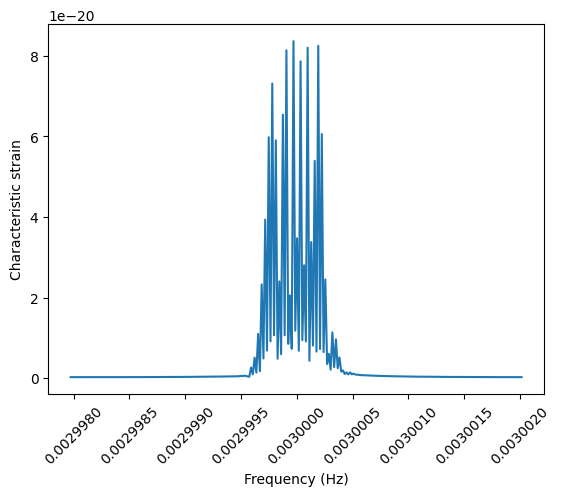

In [ ]:
from lisaorbits import EqualArmlengthOrbits
from lisatools.utils.constants import YRSID_SI

# Example of a GB waveform
orbits = EqualArmlengthOrbits()
fastgb_gen = fastgb.FastGB(orbits=orbits, T=2 * YRSID_SI, delta_t=10.0, N=256)
gb_gen = GBGen(fastgb_gen)
gb_params = GBSource(amp=2e-23, f0=3e-3, fdot=7.538331e-18, phi0=0.1, inc=0.2, psi=0.3, lam=0.4, beta=0.5)
gb_waveform = gb_gen(gb_params, squeeze=True)

plt.xticks(rotation=45)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.plot(gb_waveform.frequencies, gb_waveform.frequencies * np.abs(gb_waveform.A))

# Delete the variables of this example
del orbits, fastgb_gen, gb_gen, gb_params, gb_waveform


# Task 1: Fit a single GB source

Run a fixed-dimensional MCMC run with a chosen GB source. The noise is also assumed known.

## Prepare data injection

The data we inject will be a single GB signal only. We download from the indico page a file containing several GB parameters.

In [ ]:
!wget https://indico.in2p3.fr/event/33255/contributions/142249/attachments/87343/132329/gb_params_for_rj.npy

gb_params = np.load("gb_params_for_rj.npy")

param_map = {"f0": "Frequency",
             "fdot": "FrequencyDerivative",
             "amp": "Amplitude",
             "beta": "EclipticLatitude",
             "lam": "EclipticLongitude",
             "psi": "Polarization",
             "inc": "Inclination",
             "phi0": "InitialPhase"}

--2024-10-10 14:32:21--  https://indico.in2p3.fr/event/33255/contributions/142249/attachments/87343/132329/gb_params_for_rj.npy
Resolving indico.in2p3.fr (indico.in2p3.fr)... 134.158.243.59
Connecting to indico.in2p3.fr (indico.in2p3.fr)|134.158.243.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680 [application/octet-stream]
Saving to: ‘gb_params_for_rj.npy.1’

gb_params_for_rj.np 100%[===================>]     680  --.-KB/s    in 0s      

2024-10-10 14:32:21 (244 MB/s) - ‘gb_params_for_rj.npy.1’ saved [680/680]



In [ ]:
# We inject the first GB source

inj_dict = {key: gb_params[0][param_map[key]] for key in GBSource.keys()}
injection_src = GBSource(**inj_dict)
injection_src

GBSource(amp=1.8326657820908912e-23, f0=0.006009098866294652, fdot=2.755088767708786e-16, phi0=2.504337144699295, inc=0.8694902600959342, psi=5.053288418125767, lam=5.17647019318475, beta=0.6865491022703035)

### Inject data

We will compute the likelihood in high-level way. To that end, we need to prepare data using containers provided by https://github.com/mikekatz04/LISAanalysistools.

In [ ]:
from lisatools.datacontainer import DataResidualArray

# Helper function
def get_inband_indices(f_arr, inband_freqs):
  inband_onset = np.searchsorted(f_arr, inband_freqs[0], side="left")
  inband_end = np.searchsorted(f_arr, inband_freqs[-1], side="right")
  inband_idx = np.arange(inband_onset, inband_end)
  return inband_idx

# The injection datastream needs to span from frequency 0 to 1/delta_t
Tobs, delta_t = YRSID_SI, 5.0
# Modify Tobs so that is an integer multiple of delta_t
Tobs = int(Tobs / delta_t) * delta_t
df = 1 / Tobs
## We will use this fastgb_gen in the following
orbits = EqualArmlengthOrbits()
fastgb_gen = fastgb.FastGB(orbits=orbits, T=Tobs, delta_t=delta_t, N=256)
## Finally make the injection data
f_arr = np.arange(0.0, 1/(2 * delta_t) + df, df)

def get_data_res_arr(src, return_inband_idx=False):
  gb_gen = GBGen(fastgb_gen)
  wav = gb_gen(src, squeeze=False)
  data_arr = np.zeros((2, len(f_arr)), dtype=np.complex128)
  if return_inband_idx:
    # Initialisation
    onset, end = len(f_arr), 0
  for idx in range(wav.frequencies.shape[0]):
    inband_idx = get_inband_indices(f_arr, wav.frequencies[idx])
    data_arr[0, inband_idx] += wav.A[idx]
    data_arr[1, inband_idx] += wav.E[idx]
    data_res_arr = DataResidualArray(data_arr, f_arr = f_arr)
    if return_inband_idx:
      onset = min(onset, inband_idx[0])
      end = max(end, inband_idx[-1])
  if return_inband_idx:
    return data_res_arr, np.arange(onset, end+1)
  return data_res_arr

inj_data = get_data_res_arr(injection_src)

## Likelihood

Now we set up the log-likelihood function to feed the sampler. Recall the likelihood formula,
$$
\Lambda (d|\theta) = -\frac{1}{2} (s(\theta) - d|s(\theta) - d),
$$ where the scalar product is given by,
$$ (a | b) = 4 \Re \int_{f>0} \frac{\tilde{a}(f) \tilde{b}^*(f)}{S_n(f)}\, df.$$
We need the noise PSD to compute the likelihood.

Here we use the high-level container [`AE1SensitivityMatrix`](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.AE1SensitivityMatrix) to provide the noise PSD,
and we use [`AnalysisContainer`](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer) to compute the log-likelihood.

In [ ]:
from lisatools.sensitivity import AE1SensitivityMatrix
from lisatools.analysiscontainer import AnalysisContainer

fixed_params = {"lam": injection_src.lam, "beta": injection_src.beta}
fixed_indice = {key: index for index, key in enumerate(GBSource.keys()) if fixed_params.get(key) is not None}
fit_indice = {key: index for index, key in enumerate(GBSource.keys()) if fixed_params.get(key) is None}

def src_wrap(x: np.ndarray):
  """Return a GB source."""
  x = x.copy()
  # If x is of shape (n, ) reshape it to (1,n)
  if len(x.shape) == 1:
    x = x.reshape((1, -1))
  input_params = np.zeros((x.shape[0], len(fit_indice.keys()) + len(fixed_indice.keys())))
  input_params[:, list(fit_indice.values())] = x
  input_params[:, list(fixed_indice.values())] = np.array(list(fixed_params.values()))
  src_dict = {key: input_params[:, index] for index, key in enumerate(GBSource.keys())}
  src = GBSource(**src_dict)
  return src


class LikelihoodWrap:
    """Wrapper for the likelihood."""

    def __init__(self, data: DataResidualArray, gb_gen: GBGen = GBGen(fastgb_gen)) -> None:
      self.data = data
      self.gb_gen = gb_gen

    def __call__(self, x: np.ndarray):
      """Return the likelihood."""
      src = src_wrap(x)
      temp_wav = self.gb_gen(src, squeeze=True)
      template = DataResidualArray(np.array([temp_wav.A, temp_wav.E]), f_arr = temp_wav.frequencies)
      # Match the frequencies
      inband_idx = get_inband_indices(self.data.f_arr, temp_wav.frequencies)
      data_inband = DataResidualArray(self.data.data_res_arr[:, inband_idx], f_arr=self.data.f_arr[inband_idx])
      # Get the sensitivity
      sens_mat = AE1SensitivityMatrix(data_inband.f_arr)
      analysis = AnalysisContainer(data_inband, sens_mat)
      return analysis.template_likelihood(template)


## Sampling

Finally we have gone through all the preparation work and we are about to start the sampling.

Fix the sky location for now to simplify the problem computationally. So, you will sample over 6 of the 8 parameters.

### Prior distribution

For simplicity, we recommond using tightly (but not too tightly) bound uniform distributions as priors for this example setup. You may also think about more reasonable priors for these parameters after having finished the tutorial.

In [ ]:
from eryn.prior import uniform_dist, ProbDistContainer

# Define the priors
fit_params = {"amp": uniform_dist(1e-24, 1e-22),
              "f0": uniform_dist(0.00600905, 0.00600915),
              "fdot": uniform_dist(1e-16, 1e-15),
              "phi0": uniform_dist(0.0, 2 * np.pi),
              "inc": uniform_dist(0.0, np.pi),
              "psi": uniform_dist(0.0, np.pi)}

priors = {"gb": ProbDistContainer({
  fit_indice[key]: fit_params[key] for key in fit_params
})}

### Run

✅ Consult Eryn documentation to set up an ensemble sampler and run.
- [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html)
- [State](https://mikekatz04.github.io/Eryn/html/user/state.html)

You may use 24 walkers and 10 temperatures. Leave the kwarg `move` to None as default, and the sampler will use [StrechMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.StretchMove) as the proposal.

In [ ]:
# Do the MCMC with Eryn

from eryn.ensemble import EnsembleSampler
from eryn.state import State

ll = LikelihoodWrap(inj_data)

ndims = {"gb": 6}
nwalkers = 24
ntemps = 10
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    ll,
    priors,
    branch_names=["gb"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max={"gb": 1},
)

start_state = State({"gb": priors["gb"].rvs(size=(ntemps, nwalkers, 1))})

nsteps = 2000
sampler.run_mcmc(start_state, nsteps, burn=1000, progress=True)

100%|██████████| 2000/2000 [10:18<00:00,  3.23it/s]


### Have a look at the results

In [ ]:
from chainconsumer import Chain, ChainConsumer
import pandas as pd

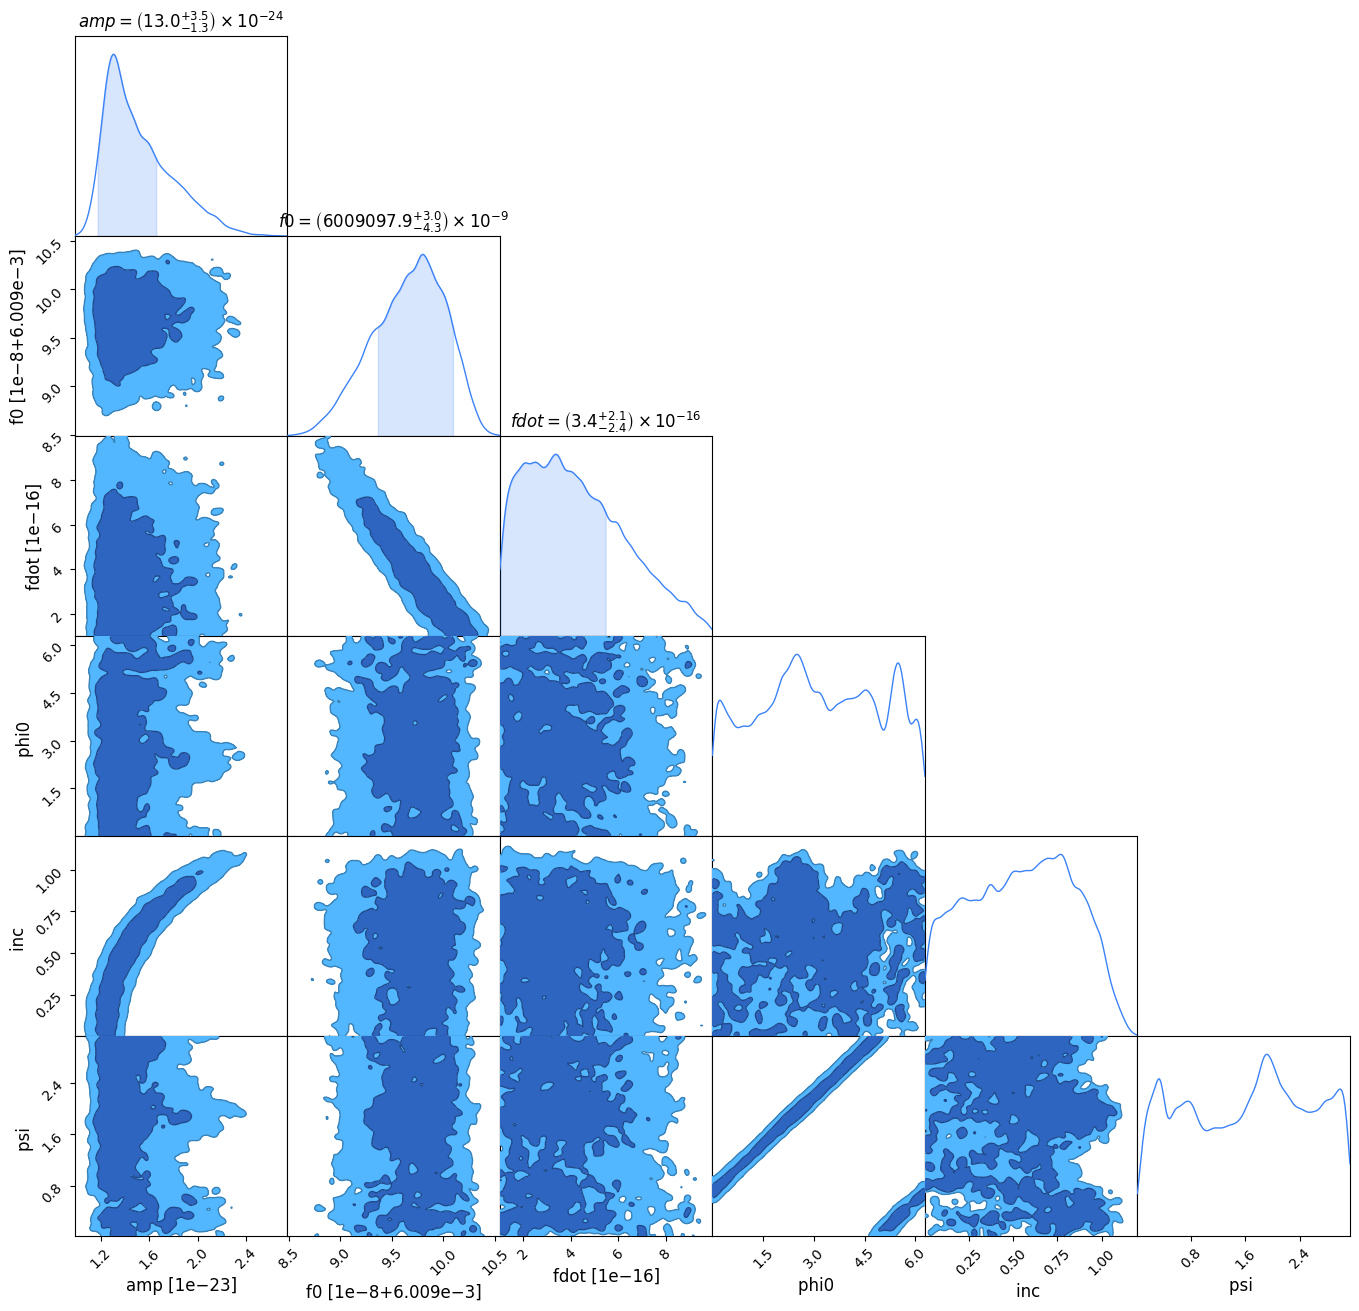

In [ ]:
cold_chain = sampler.get_chain()["gb"][:, 0, :, 0].reshape(-1, 6)
c = ChainConsumer()

df1 = pd.DataFrame({name: val for name, val in zip(["amp", "f0", "fdot", "phi0", "inc", "psi"], cold_chain.T)})
c.add_chain(Chain(samples=df1, name=str(1)))
fig = c.plotter.plot()

In [ ]:
sampler.get_last_sample()

# Task 2: RJ with GBs


Our final task will be to run RJMCMC on a few close Galactic Binaries. RJ stands for "Reversible Jump", a sampling technique for varying parameter space dimensions.

In this task the number of GB sources is not assumed known, thus the dimension of the total parameter space varies. In `Eryn`, it is a matter of setting a parameter to turn on RJ moves as we will see later.

## Prepare data injection

We inject all the sources from the downloaded file.

In [ ]:
inj_dict = {key: gb_params[param_map[key]] for key in GBSource.keys()}
injection_src = GBSource(**inj_dict)
injection_src

GBSource(amp=array([1.83266578e-23, 2.04901852e-23, 3.88905002e-23, 1.19802491e-23,
       5.29896954e-23]), f0=array([0.0060091 , 0.00600804, 0.00600753, 0.00600891, 0.00600657]), fdot=array([2.75508877e-16, 3.37503455e-16, 4.08935525e-16, 2.91201603e-16,
       9.08481384e-16]), phi0=array([2.50433714, 4.69358319, 1.83156719, 3.71124844, 1.58906226]), inc=array([0.86949026, 0.89607232, 1.29390913, 1.02979955, 2.54539867]), psi=array([5.05328842, 5.2220428 , 3.83467817, 5.06482883, 2.08691736]), lam=array([5.17647019, 4.71151197, 4.4971321 , 4.48811138, 4.71150164]), beta=array([ 0.6865491 , -0.03952825, -0.21236962, -0.25323081,  0.04570845]))

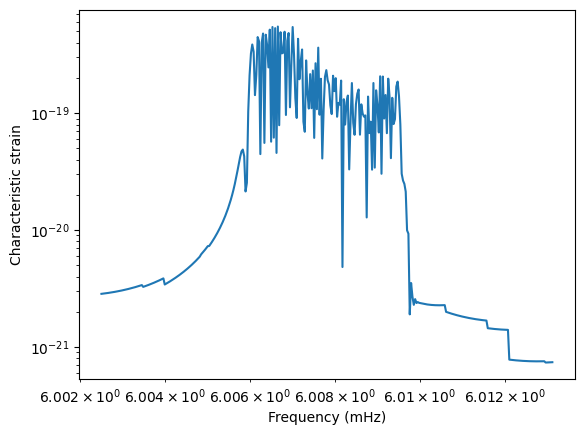

In [ ]:
inj_data, inband_idx = get_data_res_arr(injection_src, True)

plt.xlabel("Frequency (mHz)")
plt.ylabel("Characteristic strain")
plt.loglog(inj_data.f_arr[inband_idx]*1e3, inj_data.f_arr[inband_idx] * np.abs(inj_data.data_res_arr[0, inband_idx]))

## Likelihood

We need a likelihood function that takes charge of multiple sources.

In [ ]:
class MultiSourceLikelihoodWrap:
    """Wrapper for the likelihood."""

    def __init__(self, data: DataResidualArray, gb_gen: GBGen = GBGen(fastgb_gen)) -> None:
      self.data = data
      self.gb_gen = gb_gen

    def __call__(self, x: np.ndarray):
      """Return the likelihood."""
      multi_src = src_wrap(x)
      template, inband_idx = get_data_res_arr(multi_src, return_inband_idx=True)
      # Match the frequencies
      template_inband = DataResidualArray(template.data_res_arr[:, inband_idx], f_arr=template.f_arr[inband_idx])
      data_inband = DataResidualArray(self.data.data_res_arr[:, inband_idx], f_arr=self.data.f_arr[inband_idx])
      # Get the sensitivity
      sens_mat = AE1SensitivityMatrix(data_inband.f_arr)
      analysis = AnalysisContainer(data_inband, sens_mat)
      return analysis.template_likelihood(template_inband)

## Sampling

### Sampling proposal (aka Move)

The previously used `StrechMove` cannot be used to jump to other dimensions. The default [`GaussianMove`](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove) requires an inversion of the covariance matrix and is prone to numerical instabilities due to the scale differences between GB parameters.

There is a small variety of ways to deal with this. Here are two possibilities:

1) You can log scale and reduce each parmeter so they are all of order 1. This would involve changing the priors and making sure you include this conversion in your likelihood function. You can use [`eryn.utils.TransformContainer`](https://mikekatz04.github.io/Eryn/html/user/utils.html#eryn.utils.TransformContainer) to do this conversion if you would like.

2) You can create your own proposal where you assume a diagonal covariance to proceed. We take this route for this example.

In [ ]:
from eryn.moves import MHMove

class NonScaledDiagonalGaussianMove(MHMove):
    def __init__(self, cov_all, *args, **kwargs):

        for branch_name, cov in cov_all.items():
            assert isinstance(cov, np.ndarray) and cov.ndim == 1

        self.cov = cov_all
        super(NonScaledDiagonalGaussianMove, self).__init__(*args, **kwargs)

    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):

        assert branches_inds is not None
        new_points = {}
        for name, cov in self.cov.items():
            assert name in branches_coords
            coords = branches_coords[name]
            inds = branches_inds[name]

            ntemps, nwalkers, nleaves_max, ndim = coords.shape

            # generate sigma from normal distribution
            sigma = random.randn(ntemps, nwalkers)

            tmp = np.zeros_like(coords)

            tmp = coords + sigma[:, :, None, None] * cov[None, None, None, :]
            # symmetric
            new_points[name] = np.zeros_like(coords)

            # this is not necessary as the inds will remove there changes in the parent class
            # but I put it here to indicate to think about it
            new_points[name][inds] = tmp[inds]

        # symmetric
        factors = np.zeros((ntemps, nwalkers))

        return new_points, factors

### Run

✅ Consult Eryn documentation to set up an ensemble sampler and run. Set `rj_moves=True` to use the [default RJ move](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.DistributionGenerateRJ) in Eryn.
- [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html)
- [Eryn RJMCMC tutorial](https://mikekatz04.github.io/Eryn/html/tutorial/Eryn_tutorial.html#The-Tree-Metaphor)

It is important to set the kwarg `move` in this case, as the default `StrechMove` does not help to jump between dimensions.

If you can run the sampler and confirm the likelihoods are working, then consider this completed. The time alloted for the tutorial and the overall setup needed to run this RJ setup correclty require a lot more runtime for reasonable results. So, you can plot what comes out, but it will become more accurate as your run the sampler longer.

In [ ]:
fit_params = {"amp": uniform_dist(1e-24, 1e-22),
              "f0": uniform_dist(0.0060000, 0.00600900),
              "fdot": uniform_dist(1e-16, 1e-15),
              "phi0": uniform_dist(0.0, 2 * np.pi),
              "inc": uniform_dist(0.0, np.pi),
              "psi": uniform_dist(0.0, np.pi)}

nleaves_max = {"gb": 10}
nleaves_min = {"gb": 0}
ndims = {"gb": 6}

nwalkers = 14
ntemps = 12

cov = {"gb": np.array([1e-24, 1e-10, 1e-19, 0.01, 0.01, 0.01])}
moves = NonScaledDiagonalGaussianMove(cov)

ll = MultiSourceLikelihoodWrap(inj_data)

sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    ll,
    priors,
    branch_names=["gb"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj_moves=True,
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps)
)


start_points = {"gb": priors["gb"].rvs(size=(ntemps, nwalkers, nleaves_max["gb"]))}
inds_tmp = np.zeros((ntemps, nwalkers, nleaves_max["gb"]), dtype=bool)
inds_tmp[:, :, 1] = True

start_state = State(start_points, inds={"gb": inds_tmp})

nsteps = 100
end_state = sampler_rj.run_mcmc(start_state, nsteps, burn=10, progress=True)

100%|██████████| 100/100 [1:01:45<00:00, 37.06s/it]
